In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)
# Print all of the classes mapped to the Base
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# reflect an existing database into a new model
# Save references to each table
Measurement=Base.classes.measurement
Station=Base.classes.station
# Create our session (link) from Python to the DB
session=Session(engine)

# Exploratory Precipitation Analysis

In [6]:
# Find the most recent date in the data set.
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
year_no=int(last_date[0][0:4])
month_no=int(last_date[0][5:7])
date_no=int(last_date[0][8:])

# check for leap year
import calendar
if calendar.isleap(year_no) and month_no==2 and date_no==29:
    year_ago=dt.datetime.strptime(last_date[0],'%Y-%m-%d').date()- dt.timedelta(days=365)
else:
    year_ago=dt.datetime.strptime(f'{year_no-1}-{month_no}-{date_no}','%Y-%m-%d').date()
print(last_date[0],year_ago)

2017-08-23 2016-08-23


In [7]:
# Perform a query to retrieve the date and precipitation values
query_prcp=session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df=pd.DataFrame(query_prcp, columns=['date','prcp'])

# change the date datetype to  datetime
prcp_df['date'] =pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')

# Sort the dataframe by date
prcp_df=prcp_df.sort_values(by=['date'])

# drop the Null values
prcp_df=prcp_df.dropna()

# set the dataframe index to date
prcp_df=prcp_df.set_index('date')
prcp_df

,prcp
date,
2016-08-24,1.45
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.15
2016-08-24,2.28
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


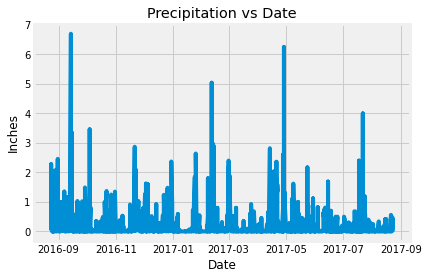

In [8]:
# Use Pandas Plotting with Matplotlib to plot the data
%matplotlib inline
plt.plot(prcp_df)
plt.title("Precipitation vs Date")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [10]:
# Design a query to calculate the total number stations in the dataset
station_list=set(session.query(Measurement.station).all())
print(f'There are {len(station_list)} stations in the dataset.')

There are 9 stations in the dataset.


In [11]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station=session.query(Measurement.station,func.count(Measurement.station)).\
            group_by (Measurement.station). order_by (func.count(Measurement.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station=active_station[0][0]
temp_min=session.query(Measurement.tobs).\
        filter(Measurement.station==most_active_station).order_by(Measurement.tobs).first()
temp_max=session.query(Measurement.tobs).\
        filter(Measurement.station==most_active_station).order_by(Measurement.tobs.desc()).first()
temp_avg=session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.station==most_active_station).all()

print(f'The most active station is {most_active_station}.')
print(f'The lowest temperature oberved is {temp_min[0]}F.')
print(f'The highest temperature oberved is {temp_max[0]}F.')
print(f'The average oberved temperature is {round(temp_avg[0][0],1)}F.')

The most active station is USC00519281.
The lowest temperature oberved is 54.0F.
The highest temperature oberved is 85.0F.
The average oberved temperature is 71.7F.


In [13]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 
last_date=session.query(Measurement.date).\
        filter(Measurement.station==most_active_station).\
        order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
year_no=int(last_date[0][0:4])
month_no=int(last_date[0][5:7])
date_no=int(last_date[0][8:])

# check for leap year
import calendar
if calendar.isleap(year_no) and month_no==2 and date_no==29:
    year_ago=dt.datetime.strptime(last_date[0],'%Y-%m-%d').date()- dt.timedelta(days=365)
else:
    year_ago=dt.datetime.strptime(f'{year_no-1}-{month_no}-{date_no}','%Y-%m-%d').date()
print(last_date[0],year_ago)

temp_date=session.query(Measurement.date,Measurement.tobs).\
        filter((Measurement.station==most_active_station),(Measurement.date > year_ago)).all()

temp_df=pd.DataFrame(temp_date, columns=['date','tobs'])

# change the date datetype to  datetime
temp_df['date'] =pd.to_datetime(temp_df['date'], format='%Y-%m-%d')

# Sort the dataframe by date
temp_df=temp_df.sort_values(by=['date'])

# drop the Null values
temp_df=temp_df.dropna()

# set the dataframe index to date
temp_df=temp_df.set_index('date')
temp_df

2017-08-18 2016-08-18


,tobs
date,
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0
2016-08-23,77.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


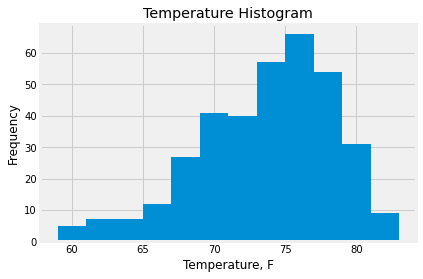

In [14]:
# plot the results as a histogram
%matplotlib inline
plt.hist(temp_df['tobs'], bins=12)
plt.title("Temperature Histogram")
plt.xlabel("Temperature, F")
plt.ylabel("Frequency")
plt.show()

# Close session

In [15]:
# Close Session
session.close()